In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import pickle as pkl
import time

tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
def leaky_relu(x, alpha=0.0001):
    return tf.maximum(alpha * x, x)

In [3]:
########################
### DATASET
########################

mnist = input_data.read_data_sets('./dataset/MNIST_data')

W0628 01:45:00.755923 139803829532480 deprecation.py:323] From <ipython-input-3-f648c7179838>:5: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0628 01:45:00.756844 139803829532480 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0628 01:45:00.757553 139803829532480 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instruction

Extracting ./dataset/MNIST_data/train-images-idx3-ubyte.gz


W0628 01:45:00.962716 139803829532480 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0628 01:45:00.999754 139803829532480 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting ./dataset/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./dataset/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./dataset/MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:

#########################
### SETTINGS
#########################

# Hyperparameters
learning_rate = 0.001
training_epochs = 300
batch_size = 64
dropout_rate = 0.5

# Other settings
print_interval = 200

# Architecture
dis_input_size = 784
gen_input_size = 100

dis_hidden_size = 128
gen_hidden_size = 128


#########################
### GRAPH DEFINITION
#########################

g = tf.Graph()
with g.as_default():
    
    # Placeholders for settings
    dropout = tf.placeholder(tf.float32, shape=None, name='dropout')
    is_training = tf.placeholder(tf.bool, shape=None, name='is_training')
    
    # Input data
    dis_x = tf.placeholder(tf.float32, shape=[None, dis_input_size], name='discriminator_input') 
    gen_x = tf.placeholder(tf.float32, [None, gen_input_size], name='generator_input')


    ##################
    # Generator Model
    ##################

    with tf.variable_scope('generator'):
        # linear -> ~~batch norm~~ -> leaky relu -> dropout -> tanh output
        gen_hidden = tf.layers.dense(inputs=gen_x, units=gen_hidden_size,
                                      activation=None)
        #gen_hidden = tf.layers.batch_normalization(gen_hidden, training=is_training)
        gen_hidden = leaky_relu(gen_hidden)
        gen_hidden = tf.layers.dropout(gen_hidden, rate=dropout_rate)
        gen_logits = tf.layers.dense(inputs=gen_hidden, units=dis_input_size, 
                                     activation=None)
        gen_out = tf.tanh(gen_logits, 'generator_output')


    ######################
    # Discriminator Model
    ######################
    
    def build_discriminator_graph(input_x, reuse=None):
        # linear -> ~~batch norm~~ -> leaky relu -> dropout -> sigmoid output
        with tf.variable_scope('discriminator', reuse=reuse):
            hidden = tf.layers.dense(inputs=input_x, units=dis_hidden_size, 
                                     activation=None)
            #hidden = tf.layers.batch_normalization(hidden, training=is_training)
            hidden = leaky_relu(hidden)
            hidden = tf.layers.dropout(hidden, rate=dropout_rate)
            logits = tf.layers.dense(inputs=hidden, units=1, activation=None)
            out = tf.sigmoid(logits)
        return logits, out    

    # Create a discriminator for real data and a discriminator for fake data
    dis_real_logits, dis_real_out = build_discriminator_graph(dis_x, reuse=False)
    dis_fake_logits, dis_fake_out = build_discriminator_graph(gen_out, reuse=True)


    #####################################
    # Generator and Discriminator Losses
    #####################################
    
    # Two discriminator cost components: loss on real data + loss on fake data
    # Real data has class label 0, fake data has class label 1
    dis_real_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_real_logits, 
                                                            labels=tf.zeros_like(dis_real_logits))
    dis_fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_fake_logits, 
                                                            labels=tf.ones_like(dis_fake_logits))
    dis_cost = tf.add(tf.reduce_mean(dis_fake_loss), 
                      tf.reduce_mean(dis_real_loss), 
                      name='discriminator_cost')
 
    # Generator cost: difference between dis. prediction and label "0" for real images
    gen_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_fake_logits,
                                                       labels=tf.zeros_like(dis_fake_logits))
    gen_cost = tf.reduce_mean(gen_loss, name='generator_cost')
    
    
    #########################################
    # Generator and Discriminator Optimizers
    #########################################
      
    dis_optimizer = tf.train.AdamOptimizer(learning_rate)
    dis_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='discriminator')
    dis_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')
    
    with tf.control_dependencies(dis_update_ops): # required to upd. batch_norm params
        dis_train = dis_optimizer.minimize(dis_cost, var_list=dis_train_vars,
                                           name='train_discriminator')
    
    gen_optimizer = tf.train.AdamOptimizer(learning_rate)
    gen_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='generator')
    gen_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
    
    with tf.control_dependencies(gen_update_ops): # required to upd. batch_norm params
        gen_train = gen_optimizer.minimize(gen_cost, var_list=gen_train_vars,
                                           name='train_generator')
    
    # Saver to save session for reuse
    saver = tf.train.Saver()

W0628 01:45:01.181890 139803829532480 deprecation.py:323] From <ipython-input-4-1df12a20b3c7>:46: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0628 01:45:01.186197 139803829532480 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0628 01:45:01.585431 139803829532480 deprecation.py:323] From <ipython-input-4-1df12a20b3c7>:49: dropout (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dropout instead.
W0628 01:45:01.697233 139803829532480 deprecation.py:323] From /usr/local/lib/python3.6/d

In [5]:
##########################
### TRAINING & EVALUATION
##########################

with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    
    avg_costs = {'discriminator': [], 'generator': []}
    start_time = time.time()
    
    for epoch in range(training_epochs):
        dis_avg_cost, gen_avg_cost = 0., 0.
        total_batch = mnist.train.num_examples // batch_size

        for i in range(total_batch):
            
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            batch_x = batch_x*2 - 1 # normalize
            batch_randsample = np.random.uniform(-1, 1, size=(batch_size, gen_input_size))
            
            # Train
            _, dc = sess.run(['train_discriminator', 'discriminator_cost:0'],
                             feed_dict={'discriminator_input:0': batch_x, 
                                        'generator_input:0': batch_randsample,
                                        'dropout:0': dropout_rate,
                                        'is_training:0': True})
            _, gc = sess.run(['train_generator', 'generator_cost:0'],
                             feed_dict={'generator_input:0': batch_randsample,
                                        'dropout:0': dropout_rate,
                                        'is_training:0': True})
            
            dis_avg_cost += dc
            gen_avg_cost += gc

            if not i % print_interval:
                print("Minibatch: %03d | Dis/Gen Cost:    %.3f/%.3f" % (i + 1, dc, gc))
                

        print("Epoch:     %03d | Dis/Gen AvgCost: %.3f/%.3f" % 
              (epoch + 1, dis_avg_cost / total_batch, gen_avg_cost / total_batch))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        
        avg_costs['discriminator'].append(dis_avg_cost / total_batch)
        avg_costs['generator'].append(gen_avg_cost / total_batch)
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    saver.save(sess, save_path='./model/gan.ckpt')

Minibatch: 001 | Dis/Gen Cost:    2.111/0.722
Minibatch: 201 | Dis/Gen Cost:    0.067/3.332
Minibatch: 401 | Dis/Gen Cost:    0.099/2.563
Minibatch: 601 | Dis/Gen Cost:    0.041/4.557
Minibatch: 801 | Dis/Gen Cost:    0.094/4.085
Epoch:     001 | Dis/Gen AvgCost: 0.151/3.493
Time elapsed: 0.04 min
Minibatch: 001 | Dis/Gen Cost:    0.100/3.316
Minibatch: 201 | Dis/Gen Cost:    0.111/5.834
Minibatch: 401 | Dis/Gen Cost:    0.476/6.220
Minibatch: 601 | Dis/Gen Cost:    0.263/5.272
Minibatch: 801 | Dis/Gen Cost:    1.587/4.108
Epoch:     002 | Dis/Gen AvgCost: 0.525/4.596
Time elapsed: 0.08 min
Minibatch: 001 | Dis/Gen Cost:    0.547/2.945
Minibatch: 201 | Dis/Gen Cost:    1.233/1.222
Minibatch: 401 | Dis/Gen Cost:    1.251/1.283
Minibatch: 601 | Dis/Gen Cost:    1.407/1.694
Minibatch: 801 | Dis/Gen Cost:    1.233/1.818
Epoch:     003 | Dis/Gen AvgCost: 1.148/2.940
Time elapsed: 0.11 min
Minibatch: 001 | Dis/Gen Cost:    1.319/1.594
Minibatch: 201 | Dis/Gen Cost:    1.553/0.956
Minibatch: 

Minibatch: 601 | Dis/Gen Cost:    0.716/2.843
Minibatch: 801 | Dis/Gen Cost:    0.942/1.355
Epoch:     028 | Dis/Gen AvgCost: 1.143/1.838
Time elapsed: 1.02 min
Minibatch: 001 | Dis/Gen Cost:    1.071/1.866
Minibatch: 201 | Dis/Gen Cost:    0.821/2.029
Minibatch: 401 | Dis/Gen Cost:    1.284/2.301
Minibatch: 601 | Dis/Gen Cost:    0.864/1.892
Minibatch: 801 | Dis/Gen Cost:    1.003/2.116
Epoch:     029 | Dis/Gen AvgCost: 1.200/1.670
Time elapsed: 1.05 min
Minibatch: 001 | Dis/Gen Cost:    1.905/0.998
Minibatch: 201 | Dis/Gen Cost:    1.172/1.717
Minibatch: 401 | Dis/Gen Cost:    0.995/2.085
Minibatch: 601 | Dis/Gen Cost:    1.250/2.014
Minibatch: 801 | Dis/Gen Cost:    0.881/1.877
Epoch:     030 | Dis/Gen AvgCost: 1.167/1.692
Time elapsed: 1.09 min
Minibatch: 001 | Dis/Gen Cost:    1.285/1.810
Minibatch: 201 | Dis/Gen Cost:    0.943/1.581
Minibatch: 401 | Dis/Gen Cost:    1.359/1.902
Minibatch: 601 | Dis/Gen Cost:    0.759/1.855
Minibatch: 801 | Dis/Gen Cost:    1.227/1.267
Epoch:     

Minibatch: 201 | Dis/Gen Cost:    0.672/2.153
Minibatch: 401 | Dis/Gen Cost:    0.790/2.169
Minibatch: 601 | Dis/Gen Cost:    1.023/1.684
Minibatch: 801 | Dis/Gen Cost:    0.812/2.415
Epoch:     056 | Dis/Gen AvgCost: 0.922/2.025
Time elapsed: 2.03 min
Minibatch: 001 | Dis/Gen Cost:    1.065/2.085
Minibatch: 201 | Dis/Gen Cost:    0.963/1.867
Minibatch: 401 | Dis/Gen Cost:    0.951/1.999
Minibatch: 601 | Dis/Gen Cost:    1.299/1.550
Minibatch: 801 | Dis/Gen Cost:    0.832/1.644
Epoch:     057 | Dis/Gen AvgCost: 0.923/1.925
Time elapsed: 2.07 min
Minibatch: 001 | Dis/Gen Cost:    0.826/1.734
Minibatch: 201 | Dis/Gen Cost:    0.761/1.810
Minibatch: 401 | Dis/Gen Cost:    0.785/2.108
Minibatch: 601 | Dis/Gen Cost:    0.784/1.998
Minibatch: 801 | Dis/Gen Cost:    0.950/1.901
Epoch:     058 | Dis/Gen AvgCost: 0.965/1.864
Time elapsed: 2.10 min
Minibatch: 001 | Dis/Gen Cost:    0.786/2.033
Minibatch: 201 | Dis/Gen Cost:    1.116/1.690
Minibatch: 401 | Dis/Gen Cost:    0.995/1.890
Minibatch: 

Minibatch: 801 | Dis/Gen Cost:    1.033/1.699
Epoch:     083 | Dis/Gen AvgCost: 1.022/1.624
Time elapsed: 3.01 min
Minibatch: 001 | Dis/Gen Cost:    1.303/1.242
Minibatch: 201 | Dis/Gen Cost:    0.865/1.921
Minibatch: 401 | Dis/Gen Cost:    0.946/1.956
Minibatch: 601 | Dis/Gen Cost:    0.756/1.754
Minibatch: 801 | Dis/Gen Cost:    1.179/1.532
Epoch:     084 | Dis/Gen AvgCost: 1.016/1.643
Time elapsed: 3.04 min
Minibatch: 001 | Dis/Gen Cost:    1.544/1.526
Minibatch: 201 | Dis/Gen Cost:    0.867/1.443
Minibatch: 401 | Dis/Gen Cost:    1.001/1.559
Minibatch: 601 | Dis/Gen Cost:    0.973/1.867
Minibatch: 801 | Dis/Gen Cost:    0.852/1.762
Epoch:     085 | Dis/Gen AvgCost: 1.022/1.615
Time elapsed: 3.08 min
Minibatch: 001 | Dis/Gen Cost:    1.288/1.558
Minibatch: 201 | Dis/Gen Cost:    0.879/1.642
Minibatch: 401 | Dis/Gen Cost:    0.889/1.829
Minibatch: 601 | Dis/Gen Cost:    1.279/1.383
Minibatch: 801 | Dis/Gen Cost:    1.047/1.945
Epoch:     086 | Dis/Gen AvgCost: 1.005/1.664
Time elapse

Minibatch: 201 | Dis/Gen Cost:    1.012/1.276
Minibatch: 401 | Dis/Gen Cost:    1.018/1.395
Minibatch: 601 | Dis/Gen Cost:    0.898/1.546
Minibatch: 801 | Dis/Gen Cost:    1.089/1.787
Epoch:     111 | Dis/Gen AvgCost: 0.990/1.603
Time elapsed: 4.02 min
Minibatch: 001 | Dis/Gen Cost:    0.819/1.917
Minibatch: 201 | Dis/Gen Cost:    0.936/1.619
Minibatch: 401 | Dis/Gen Cost:    0.862/1.933
Minibatch: 601 | Dis/Gen Cost:    0.981/1.387
Minibatch: 801 | Dis/Gen Cost:    0.948/1.298
Epoch:     112 | Dis/Gen AvgCost: 1.000/1.620
Time elapsed: 4.06 min
Minibatch: 001 | Dis/Gen Cost:    1.122/1.785
Minibatch: 201 | Dis/Gen Cost:    1.002/1.431
Minibatch: 401 | Dis/Gen Cost:    1.027/2.054
Minibatch: 601 | Dis/Gen Cost:    0.761/1.860
Minibatch: 801 | Dis/Gen Cost:    1.042/1.970
Epoch:     113 | Dis/Gen AvgCost: 0.988/1.624
Time elapsed: 4.09 min
Minibatch: 001 | Dis/Gen Cost:    1.093/1.576
Minibatch: 201 | Dis/Gen Cost:    1.177/1.448
Minibatch: 401 | Dis/Gen Cost:    1.019/1.515
Minibatch: 

Minibatch: 801 | Dis/Gen Cost:    0.956/1.882
Epoch:     138 | Dis/Gen AvgCost: 0.994/1.608
Time elapsed: 5.00 min
Minibatch: 001 | Dis/Gen Cost:    0.794/1.685
Minibatch: 201 | Dis/Gen Cost:    0.851/1.788
Minibatch: 401 | Dis/Gen Cost:    0.916/1.673
Minibatch: 601 | Dis/Gen Cost:    0.934/2.116
Minibatch: 801 | Dis/Gen Cost:    1.138/1.377
Epoch:     139 | Dis/Gen AvgCost: 0.984/1.604
Time elapsed: 5.03 min
Minibatch: 001 | Dis/Gen Cost:    1.137/1.398
Minibatch: 201 | Dis/Gen Cost:    0.927/1.597
Minibatch: 401 | Dis/Gen Cost:    0.965/1.412
Minibatch: 601 | Dis/Gen Cost:    1.040/1.476
Minibatch: 801 | Dis/Gen Cost:    1.206/1.365
Epoch:     140 | Dis/Gen AvgCost: 0.984/1.571
Time elapsed: 5.07 min
Minibatch: 001 | Dis/Gen Cost:    0.917/2.086
Minibatch: 201 | Dis/Gen Cost:    1.075/1.911
Minibatch: 401 | Dis/Gen Cost:    1.142/1.416
Minibatch: 601 | Dis/Gen Cost:    0.904/1.706
Minibatch: 801 | Dis/Gen Cost:    0.822/1.780
Epoch:     141 | Dis/Gen AvgCost: 0.981/1.591
Time elapse

Minibatch: 201 | Dis/Gen Cost:    1.104/1.411
Minibatch: 401 | Dis/Gen Cost:    1.043/1.604
Minibatch: 601 | Dis/Gen Cost:    0.884/1.621
Minibatch: 801 | Dis/Gen Cost:    0.970/1.434
Epoch:     166 | Dis/Gen AvgCost: 0.965/1.612
Time elapsed: 6.01 min
Minibatch: 001 | Dis/Gen Cost:    1.020/1.335
Minibatch: 201 | Dis/Gen Cost:    0.908/1.485
Minibatch: 401 | Dis/Gen Cost:    1.037/1.829
Minibatch: 601 | Dis/Gen Cost:    0.959/1.392
Minibatch: 801 | Dis/Gen Cost:    0.952/1.574
Epoch:     167 | Dis/Gen AvgCost: 0.963/1.608
Time elapsed: 6.05 min
Minibatch: 001 | Dis/Gen Cost:    1.249/1.391
Minibatch: 201 | Dis/Gen Cost:    0.864/1.825
Minibatch: 401 | Dis/Gen Cost:    0.928/1.792
Minibatch: 601 | Dis/Gen Cost:    1.009/1.457
Minibatch: 801 | Dis/Gen Cost:    1.001/1.688
Epoch:     168 | Dis/Gen AvgCost: 0.952/1.602
Time elapsed: 6.09 min
Minibatch: 001 | Dis/Gen Cost:    0.986/1.581
Minibatch: 201 | Dis/Gen Cost:    0.972/1.288
Minibatch: 401 | Dis/Gen Cost:    0.925/1.907
Minibatch: 

Minibatch: 801 | Dis/Gen Cost:    1.053/1.447
Epoch:     193 | Dis/Gen AvgCost: 0.947/1.628
Time elapsed: 6.99 min
Minibatch: 001 | Dis/Gen Cost:    0.933/1.463
Minibatch: 201 | Dis/Gen Cost:    0.759/1.658
Minibatch: 401 | Dis/Gen Cost:    0.878/1.757
Minibatch: 601 | Dis/Gen Cost:    0.945/1.837
Minibatch: 801 | Dis/Gen Cost:    0.893/1.576
Epoch:     194 | Dis/Gen AvgCost: 0.952/1.622
Time elapsed: 7.03 min
Minibatch: 001 | Dis/Gen Cost:    1.047/1.365
Minibatch: 201 | Dis/Gen Cost:    0.868/1.697
Minibatch: 401 | Dis/Gen Cost:    0.903/1.754
Minibatch: 601 | Dis/Gen Cost:    0.874/1.607
Minibatch: 801 | Dis/Gen Cost:    0.892/1.712
Epoch:     195 | Dis/Gen AvgCost: 0.954/1.592
Time elapsed: 7.06 min
Minibatch: 001 | Dis/Gen Cost:    1.155/1.235
Minibatch: 201 | Dis/Gen Cost:    0.987/1.741
Minibatch: 401 | Dis/Gen Cost:    0.958/1.287
Minibatch: 601 | Dis/Gen Cost:    0.950/1.626
Minibatch: 801 | Dis/Gen Cost:    1.005/1.435
Epoch:     196 | Dis/Gen AvgCost: 0.954/1.613
Time elapse

Minibatch: 201 | Dis/Gen Cost:    0.936/1.528
Minibatch: 401 | Dis/Gen Cost:    1.107/2.114
Minibatch: 601 | Dis/Gen Cost:    1.157/1.799
Minibatch: 801 | Dis/Gen Cost:    1.015/1.722
Epoch:     221 | Dis/Gen AvgCost: 0.943/1.676
Time elapsed: 8.01 min
Minibatch: 001 | Dis/Gen Cost:    0.815/1.665
Minibatch: 201 | Dis/Gen Cost:    0.918/1.613
Minibatch: 401 | Dis/Gen Cost:    1.012/1.748
Minibatch: 601 | Dis/Gen Cost:    0.961/1.424
Minibatch: 801 | Dis/Gen Cost:    0.960/1.719
Epoch:     222 | Dis/Gen AvgCost: 0.938/1.654
Time elapsed: 8.04 min
Minibatch: 001 | Dis/Gen Cost:    1.019/2.119
Minibatch: 201 | Dis/Gen Cost:    1.005/1.782
Minibatch: 401 | Dis/Gen Cost:    0.975/1.905
Minibatch: 601 | Dis/Gen Cost:    0.787/1.934
Minibatch: 801 | Dis/Gen Cost:    0.902/1.551
Epoch:     223 | Dis/Gen AvgCost: 0.934/1.672
Time elapsed: 8.08 min
Minibatch: 001 | Dis/Gen Cost:    1.196/1.551
Minibatch: 201 | Dis/Gen Cost:    0.932/2.394
Minibatch: 401 | Dis/Gen Cost:    1.086/1.490
Minibatch: 

Minibatch: 801 | Dis/Gen Cost:    0.934/1.794
Epoch:     248 | Dis/Gen AvgCost: 0.918/1.698
Time elapsed: 8.98 min
Minibatch: 001 | Dis/Gen Cost:    0.874/1.664
Minibatch: 201 | Dis/Gen Cost:    0.805/1.317
Minibatch: 401 | Dis/Gen Cost:    0.891/1.763
Minibatch: 601 | Dis/Gen Cost:    0.798/1.955
Minibatch: 801 | Dis/Gen Cost:    0.855/1.760
Epoch:     249 | Dis/Gen AvgCost: 0.925/1.694
Time elapsed: 9.02 min
Minibatch: 001 | Dis/Gen Cost:    0.838/1.565
Minibatch: 201 | Dis/Gen Cost:    0.933/1.549
Minibatch: 401 | Dis/Gen Cost:    0.875/1.732
Minibatch: 601 | Dis/Gen Cost:    0.885/1.687
Minibatch: 801 | Dis/Gen Cost:    0.916/1.756
Epoch:     250 | Dis/Gen AvgCost: 0.923/1.722
Time elapsed: 9.06 min
Minibatch: 001 | Dis/Gen Cost:    0.995/1.402
Minibatch: 201 | Dis/Gen Cost:    1.028/1.736
Minibatch: 401 | Dis/Gen Cost:    0.980/1.412
Minibatch: 601 | Dis/Gen Cost:    0.897/1.753
Minibatch: 801 | Dis/Gen Cost:    1.096/1.514
Epoch:     251 | Dis/Gen AvgCost: 0.925/1.716
Time elapse

Minibatch: 201 | Dis/Gen Cost:    0.930/1.651
Minibatch: 401 | Dis/Gen Cost:    1.076/1.732
Minibatch: 601 | Dis/Gen Cost:    0.774/1.536
Minibatch: 801 | Dis/Gen Cost:    0.885/1.660
Epoch:     276 | Dis/Gen AvgCost: 0.904/1.739
Time elapsed: 10.00 min
Minibatch: 001 | Dis/Gen Cost:    0.927/1.661
Minibatch: 201 | Dis/Gen Cost:    0.917/2.132
Minibatch: 401 | Dis/Gen Cost:    1.029/1.619
Minibatch: 601 | Dis/Gen Cost:    0.744/1.824
Minibatch: 801 | Dis/Gen Cost:    0.759/2.175
Epoch:     277 | Dis/Gen AvgCost: 0.901/1.794
Time elapsed: 10.03 min
Minibatch: 001 | Dis/Gen Cost:    0.823/1.659
Minibatch: 201 | Dis/Gen Cost:    0.916/1.598
Minibatch: 401 | Dis/Gen Cost:    0.803/1.834
Minibatch: 601 | Dis/Gen Cost:    0.899/1.749
Minibatch: 801 | Dis/Gen Cost:    0.920/1.920
Epoch:     278 | Dis/Gen AvgCost: 0.896/1.779
Time elapsed: 10.07 min
Minibatch: 001 | Dis/Gen Cost:    0.872/1.933
Minibatch: 201 | Dis/Gen Cost:    0.998/1.673
Minibatch: 401 | Dis/Gen Cost:    0.845/1.665
Minibatc

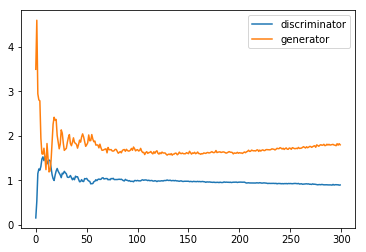

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(len(avg_costs['discriminator'])), 
         avg_costs['discriminator'], label='discriminator')
plt.plot(range(len(avg_costs['generator'])),
         avg_costs['generator'], label='generator')
plt.legend()
plt.show()

W0628 01:55:55.179756 139803829532480 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


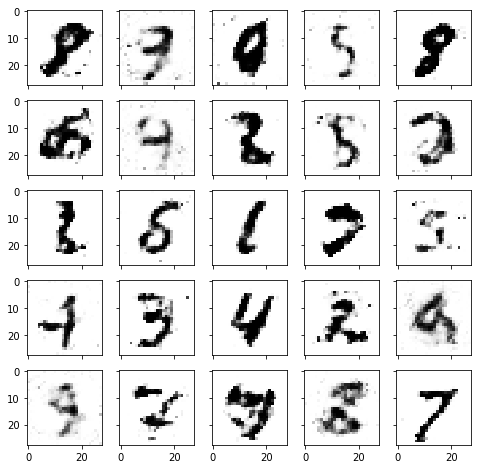

In [7]:
####################################
### RELOAD & GENERATE SAMPLE IMAGES
####################################


n_examples = 25

with tf.Session(graph=g) as sess:
    saver.restore(sess, save_path='./model/gan.ckpt')

    batch_randsample = np.random.uniform(-1, 1, size=(n_examples, gen_input_size))
    new_examples = sess.run('generator/generator_output:0',
                            feed_dict={'generator_input:0': batch_randsample,
                                       'dropout:0': 0.0,
                                       'is_training:0': False})

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8, 8),
                         sharey=True, sharex=True)

for image, ax in zip(new_examples, axes.flatten()):
    ax.imshow(image.reshape((dis_input_size // 28, dis_input_size // 28)), cmap='binary')

plt.show()